In [83]:
# Hotel booking analisys: In this analysis we are going to build a model which tries to predict in which cases a hotel booking will get cancelled.

In [84]:
#We are going to do so with open data from https://www.sciencedirect.com/science/article/pii/S2352340918315191. In this link you can find all the information about the data set.

In [85]:
#First of all we open all the libraries which will be needed for our model
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [86]:
#OPENING THE DATA & DATA PRE-PROCESSING
#dataframe = pd.read_csv('https://raw.githubusercontent.com/Antsere/My_projects/refs/heads/main/hotels.csv?token=GHSAT0AAAAAACYSO7VYK65CWWLSU45MA522ZYD55BQ')
dataframe = pd.read_csv('https://raw.githubusercontent.com/kevinasyraf/find-it-2020-dac/master/hotel_bookings.csv')
dataframe.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [87]:
# We have open the first 5 lines just to have a look to our data and see how it is organized. We go thorugh the data set explanation in
# https://www.sciencedirect.com/science/article/pii/S2352340918315191 to have a better idea of the dataset.

In [88]:
# Our goal will be to predict the column "is_canceled", that means, to predict which bookings wil be cancelled. This a a binary column,
# 0 means not cancelled and 1 means cancelled.

In [89]:
#Now lets run some checks to preprocess the data and make sure there are not missing values.

In [90]:
dataframe.shape  #this formula tells us what is the size of our table (rows, columns)

(119390, 32)

In [91]:
#formula to have an overview of the data type of our columns

In [92]:
dataframe.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [93]:
# Those which are 'object' are columns which value is not a number. For a machine learning model we need all columns part of the model
# to be columns with number as value. For that reason we will need to encode them, we will come later to that.

In [94]:
#now lets check if we have missing values 
nullvalues = dataframe.isnull().sum()
print(nullvalues)

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [95]:
#now lets reduce our output table to only the columns which have nullvalues for a clearer view
columns_nullvalues = nullvalues[nullvalues > 0]
print(columns_nullvalues)

children         4
country        488
agent        16340
company     112593
dtype: int64


In [96]:
#we have 4 columns with entries which are blank. Now we have to replace those blanks with data which will not distort the dataset.
# For that, I like to see what are the distinct values of each columns, to have an idea of the inputs that each table brings to the dataset

In [97]:

columns_with_nulls = columns_nullvalues.index
unique_values_list = []
for col in columns_with_nulls:
    unique_values_list.append((col, dataframe[col].unique()))
unique_values_df = pd.DataFrame(unique_values_list, columns=['Column', 'Unique Values'])
print(unique_values_df)

     Column                                      Unique Values
0  children                    [0.0, 1.0, 2.0, 10.0, 3.0, nan]
1   country  [PRT, GBR, USA, ESP, IRL, FRA, nan, ROU, NOR, ...
2     agent  [nan, 304.0, 240.0, 303.0, 15.0, 241.0, 8.0, 2...
3   company  [nan, 110.0, 113.0, 270.0, 178.0, 240.0, 154.0...


In [98]:
#For the purpose of the exercie and to show what are the diferents options to deal with Nan columns we are goint to take a diferent approach to each columsn


In [99]:
#Children : There are only 4 rows with Nan values, therefore we are going to replace the Nan values with 0, assuming the missing data means
# that there was no children in that booking. We use the formula 'fillna' and we select which coumns and with whihc vlaue we want to replace it

In [100]:
dataframe.fillna({'children': 0}, inplace=True)

In [101]:
# We run again the check which gives us the columns with nan values as output. Now children should not appear

In [102]:
nullvalues = dataframe.isnull().sum()
columns_nullvalues = nullvalues[nullvalues > 0]
print(columns_nullvalues)

country       488
agent       16340
company    112593
dtype: int64


In [103]:
#good! 'children' column does not appear anymore. Our replacement of NA with 0 was succesfull

In [104]:
# For the column country we are goin to replace the NAN values with the most frequent value of the column
# you have to be careful when doing this approach, but for the seek of exercise we will do so, assuming that the missing values 
# belong to the most frequent one

In [105]:
mode_country_column = dataframe['country'].mode()
print(mode_country_column)

0    PRT
Name: country, dtype: object


In [106]:
# The mode value is "PRT" = Portugal, so we are going to replace the NaN values with "PRT"
dataframe.fillna({'country': 'PRT'}, inplace=True)

In [107]:
# we run again the NaN check
nullvalues = dataframe.isnull().sum()
columns_nullvalues = nullvalues[nullvalues > 0]
print(columns_nullvalues)

agent       16340
company    112593
dtype: int64


In [108]:
# now the column country does not appear, this means our NaN -> "PRT" replacement was succesfull
# For agent column we will keep the NaN values, just to prove that a machine learning model can work with Nan values. 
# althought ideally we should find a replacement to the NaN which makes sense and do not distort the data

# For company, we see that there are 112k rows with NaN. As we saw at the begining the shape of te matrix is (119390, 32)
#that means aprox 95% of the entries for that columns are NaN. Therefore, this columns brings nothing relevant to the dataset so we will delete it

In [109]:
dataframe.drop(['company'], axis=1, inplace=True)
dataframe.shape


(119390, 31)

In [110]:
#Now our shape is (119390, 31) instead of 119390, 32, this means we have one column less so we deleted "company" succesfully
#we run again the check
nullvalues = dataframe.isnull().sum()
columns_nullvalues = nullvalues[nullvalues > 0]
print(columns_nullvalues)

agent    16340
dtype: int64


In [111]:
#now we have only agent as column with NaN, which we decided to have like that. Our first step of data cleaning is finished.

In [112]:
#Our aim is to predict "is_cancelled" and there is a column which is called "reservation status". It seems that bith contain the same information
# if so, we will delete 'reservation status' to avoid duplicites
unique_values_reservationstatus = dataframe['reservation_status'].unique()
print(unique_values_reservationstatus)

['Check-Out' 'Canceled' 'No-Show']


In [113]:
#As we can see we have the same concept that we want to predict (cancelled / not cancelled ) only that the not cancelled is divided in two conceots
# so we are going to delete this column and the one related to this one which is reservation_status_date

In [114]:
dataframe.drop(['reservation_status', 'reservation_status_date'], axis=1, inplace=True)
dataframe.shape

(119390, 29)

In [115]:
# So far we have done sense check columnwise, now lets do a sense check rowwise. 
# We want to see if there is some mistaken row, where there are 0 guest in the booking. That means, if the columnsum of adult + children + babies = 0

In [116]:
columns_to_sum = ['adults','children','babies']
index_ghost_bookings = dataframe[dataframe[columns_to_sum].sum(axis=1) == 0].index
ghost_bookings_list = list(index_ghost_bookings)
print(ghost_bookings_list)
print("the lenght of the list is: ",len(ghost_bookings_list))

[2224, 2409, 3181, 3684, 3708, 4127, 9376, 31765, 32029, 32827, 34849, 34855, 37459, 40392, 40922, 41020, 41056, 42452, 42591, 42871, 42934, 47166, 47180, 47444, 49264, 50701, 50702, 54025, 54037, 54047, 54093, 55809, 60651, 61244, 61245, 61249, 62967, 63796, 64782, 65907, 65908, 65909, 65910, 69668, 72967, 72968, 76620, 76985, 77001, 77003, 77447, 77998, 78257, 78586, 78672, 79077, 79807, 79808, 80072, 81481, 82264, 82265, 82266, 82267, 83506, 83810, 84198, 85490, 85491, 85539, 85931, 88017, 88327, 88328, 88439, 89359, 89360, 90930, 91428, 92814, 92962, 93204, 93320, 93397, 93753, 93754, 94769, 94821, 95544, 96599, 96648, 96810, 98045, 98046, 98492, 99260, 99338, 99774, 99880, 100273, 100487, 100563, 100780, 101329, 101399, 101401, 101794, 101804, 101805, 101957, 102008, 102054, 102055, 102129, 102150, 102155, 102157, 102185, 102258, 102296, 102319, 102611, 102710, 102805, 102812, 103264, 103317, 103714, 103961, 104145, 104231, 104516, 105106, 105185, 105630, 105726, 105728, 106556, 1

In [117]:
#in this index list, we have to index of the rows where the sumn of guest is 0 (ghost bookings), the list lenght is 180
#this means there are 180 lines with no guest so we are going to delete them

dataframe.drop(dataframe.index[ghost_bookings_list], inplace=True)
dataframe.shape

(119210, 29)

In [118]:
#The shape is now 119210 instead 119390, a difference of 180 rows, which is the lenght of our list with ghost bookings
#now we have the data clean. Now lets simply do a couple of visualization to get to know better our data

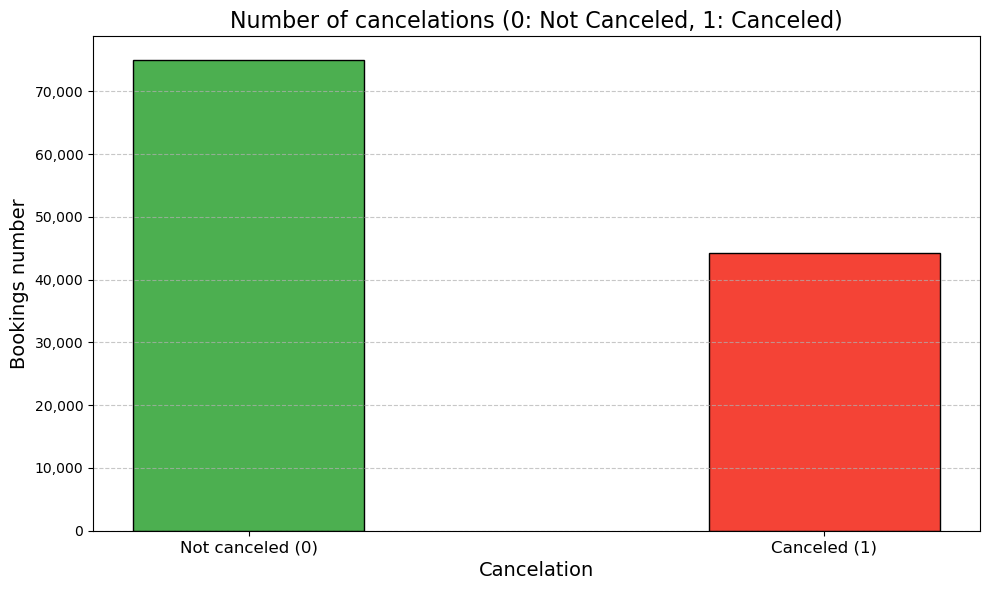

In [119]:

cancelations_count = dataframe['is_canceled'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(cancelations_count.index.astype(str), cancelations_count.values, width=0.4, color=['#4CAF50', '#F44336'], edgecolor='black')
plt.xlabel('Cancelation', fontsize=14)
plt.ylabel('Bookings number', fontsize=14)
plt.title('Number of cancelations (0: Not Canceled, 1: Canceled)', fontsize=16)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.xticks(ticks=cancelations_count.index.astype(str), labels=['Not canceled (0)', 'Canceled (1)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [120]:
print("The cancelation rate is: ", round(cancelations_count[1]/cancelations_count.sum(),4)*100, " % ")

The cancelation rate is:  37.08  % 


In [121]:
#let's build a vision with the a table with the countries of the person who did the reservation. We sort it frm countries with the biggest number of 
# bookings to the lowest. Also a column with the cancelations among those bookings and last column with the % of cancelation of that country
total_bookings = dataframe['country'].value_counts()
total_cancelations = dataframe[dataframe['is_canceled'] == 1]['country'].value_counts()
result_df = pd.DataFrame({
    'Total Bookings': total_bookings,
    'Total Cancelations': total_cancelations
}).fillna(0)  
result_df['% Cancelations'] = round((result_df['Total Cancelations'] / result_df['Total Bookings']) * 100,2)
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Country'}, inplace=True)
result_df = result_df.sort_values(by='Total Bookings', ascending=False)
print(result_df)

    country  Total Bookings  Total Cancelations  % Cancelations
135     PRT           48961             27563.0           56.30
59      GBR           12120              2452.0           20.23
56      FRA           10401              1933.0           18.58
51      ESP            8560              2177.0           25.43
43      DEU            7285              1218.0           16.72
81      ITA            3761              1333.0           35.44
76      IRL            3374               832.0           24.66
15      BEL            2342               474.0           20.24
25      BRA            2222               830.0           37.35
123     NLD            2103               387.0           18.40
169     USA            2093               501.0           23.94
29      CHE            1726               428.0           24.80
34       CN            1279               254.0           19.86
12      AUT            1263               230.0           18.21
154     SWE            1020             

In [122]:
#we can see how Portugal has a significant bigger ratio cancellation, also is the country which has the most bookings
#since the study is done in bookings for reservations done in hotels which are in Portugal, the following model could be biased 
# when trying to apply to any hotel of any part of the world, since the weight of the nationality Portugal is so big here, which could be
# much smaller for bookings of hotels of other countries

In [123]:
# After this very brief data presentation, we are done with the pre-processing and data cleaning. From this line onwards
#### we start with the machine learning model ####

In [124]:
#we are going to use the decission tree model
# First, we need to have all our columns as datatype, as we saw at the overview in the beginning, we have some columns which are 
# object type. We need to convert this categories into a numerical code. 
# To do so we have two options: Label encdoing and One hot encoding.
# Label encoding would not work so weel here, since the categories of our "object type" columns are independent. Therefore we will use One hot encoder
# which is a better option for cases where the categories are independent. The downside is that one hot encoding makes the size of the dataset much bigger

In [125]:
# Lets see which columns need to be codified:
non_numeric_dtypes = dataframe.select_dtypes(include=['object']).dtypes
print(non_numeric_dtypes.index)

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type'],
      dtype='object')


In [126]:
#THe month of arrival is in text type, lets convert it to number
meses_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
dataframe['arrival_date_month'] = dataframe['arrival_date_month'].map(meses_dict)
print(dataframe['arrival_date_month'].unique())

[ 7  8  9 10 11 12  1  2  3  4  5  6]


In [127]:
# Lets see which columns need to be codified:
non_numeric_dtypes = dataframe.select_dtypes(include=['object']).dtypes
print(non_numeric_dtypes.index)

Index(['hotel', 'meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'customer_type'],
      dtype='object')


In [128]:
#the categories of the features above have are not related so we will use a one hot encoder (this will make the size of our matrix much bigger)
unique_values = {
    'Column': [],
    'Unique Values': []
}
print(unique_values)
for col in non_numeric_dtypes.index:
    unique_values['Column'].append(col)
    unique_values['Unique Values'].append(dataframe[col].unique())

unique_df = pd.DataFrame(unique_values)
print(unique_df)
columns_onehot = list(unique_df['Column'])
print(columns_onehot)
df_encoded_one_hot = pd.get_dummies(dataframe, columns=columns_onehot, drop_first=False)

{'Column': [], 'Unique Values': []}
                 Column                                      Unique Values
0                 hotel                         [Resort Hotel, City Hotel]
1                  meal                        [BB, FB, HB, SC, Undefined]
2               country  [PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ...
3        market_segment  [Direct, Corporate, Online TA, Offline TA/TO, ...
4  distribution_channel         [Direct, Corporate, TA/TO, Undefined, GDS]
5    reserved_room_type                        [C, A, D, E, G, F, H, L, B]
6    assigned_room_type                  [C, A, D, E, G, F, I, B, H, L, K]
7          deposit_type               [No Deposit, Refundable, Non Refund]
8         customer_type      [Transient, Contract, Transient-Party, Group]
['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


In [129]:
dataframe['country'].nunique()

177

In [130]:
dataframe['country'].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'ETH', 

In [131]:
#We see that country has 177 unique values, whis would mean that we would get extra 177 columns with one hot encoder. So we are 
#going to group the values intro EU and Non_EU and then we will do the one hot encoder

eu_country_codes = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FRA',
    'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'HUN',
    'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVN', 'SWE', 'SVK','ESP'
]
dataframe['Country_cluster'] = dataframe['country'].apply(lambda x: 'UE' if x in eu_country_codes else 'No_UE')


In [132]:
# Lets see again which columns need to be codified:
non_numeric_dtypes = dataframe.select_dtypes(include=['object']).dtypes
print(non_numeric_dtypes.index)

Index(['hotel', 'meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'customer_type', 'Country_cluster'],
      dtype='object')


In [133]:
#we have now the column country and country cluster. We can drop the column country since we will use for the encoder country cluster
dataframe.drop(['country'], axis=1, inplace=True)
dataframe.shape

(119210, 29)

In [134]:
# Lets see again which columns need to be codified, we should not have "country"
non_numeric_dtypes = dataframe.select_dtypes(include=['object']).dtypes
print(non_numeric_dtypes.index)

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'customer_type', 'Country_cluster'],
      dtype='object')


In [135]:
#Now we apply the one hot encodig
columns_to_encode = list(non_numeric_dtypes.index)
dataframe_encoded = pd.get_dummies(dataframe, columns=columns_to_encode, drop_first=False)
# with the one hot encoding we increasie the size of our matrix
dataframe_encoded.shape

(119210, 69)

In [136]:
# Now we have 69 columns instead of 29, as we could expect.
# lets have a quick overview of our new dataframe
dataframe_encoded.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,Country_cluster_No_UE,Country_cluster_UE
0,0,342,2015,7,27,1,0,0,2,0.0,0,0,0,0,3,NaN,0,0.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True
1,0,737,2015,7,27,1,0,0,2,0.0,0,0,0,0,4,NaN,0,0.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2,0,7,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,NaN,0,75.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False
3,0,13,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False
4,0,14,2015,7,27,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False


In [137]:
#the columns which were objects are nor True / Flase (0/1) for each value of the feature, which is what we were looking for

In [138]:
# Now we set what is going to be our target column (what we want to predict). Our goal is "is_canceled"
X = dataframe_encoded.drop(columns=['is_canceled']) # X is our train set, which is all the data except out target 
y = dataframe_encoded['is_canceled'] # Y is our target column 'is_canceled' (this is the column we want to predict)

In [139]:
# Now lets split our dataset in training and test dataset. # Normally the standard ratio is 80 train 20 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
#We are going to use RandomForest, since our matrix is big so it would be more convinient than DecissionTree, which is more sensitive
# to overfitting
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Here we train our train data and our target train data
model.fit(X_train, y_train)
# Now lets do the predictions on the train data and see the score on our train data
predictions = model.predict(X_train)
# Evaluation of our model on train data:
accuracy = model.score(X_train, y_train)
print(f'Accuracy on train data: {accuracy}')

Accuracy on train data: 0.9928906970891703


In [141]:
# We see we have a score of 0.99 (maximum is 1). Does this mean our model is almost perfect?
# actually not, having a 0.99 means our model has learnt almost perfectly our train data. This means, the model can predict very well with known
# data. But what could the model predict with unkown data? To figure it out, we need to run outr model against the test data
# that means, the data we have "hidden" so it is like "new" data for the model and will need to predict based on what the model learnt with the train data.

In [142]:
# lets run the model on test data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Accuracy on test data: {accuracy}')

Accuracy on test data: 0.8805888767720829


In [143]:
# This is what we could expect, the model is less accurate on the test data because it is "hidden data".
# 0.88 is still a good score, now lets try to optimize de model

In [144]:
# First idea: Escale the data. Lets run the model on scaled data and compare with unscaled data. RandomForest is not very sensitive to scalation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

accuracy_scaled = model.score(X_test_scaled, y_test)
print(f'Accuracy on scaled test data: {accuracy_scaled}')


Accuracy on scaled test data: 0.8804211056119453


In [145]:
#As we can see our model it is pretty much the same with scaled data

In [148]:
# Second idea: Lets try with the "Importance feature" system. Here we try to get rid of colummns which are not important to make 
# our dataset simpler and get rid of "useless" columns
# we run it on the non-scaled data, since the scaling did not improve the score
feature_importance = model.fit(X_train, y_train).feature_importances_

#We sort the importance bigger to smaller to have a quick look
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
#We set a threshold (limit of what is not important)
threshold = 0.02
#The not important columns (smaller than the threshold), are taken out
columns_drop = feature_importances[feature_importances['Importance'] < threshold]['Feature'].tolist()
dataframe_encoded.drop(columns=columns_drop, inplace=True)

dataframe_after_columnsimportance = dataframe_encoded

print()
print("Here the columns by importance", feature_importances )
print("Columns to take out", columns_drop )
print()


Here the columns by importance                            Feature  Importance
0                        lead_time    0.131384
16                             adr    0.081981
60         deposit_type_Non Refund    0.075955
59         deposit_type_No Deposit    0.071770
4        arrival_date_day_of_month    0.062112
18       total_of_special_requests    0.059465
3         arrival_date_week_number    0.055928
14                           agent    0.048907
6             stays_in_week_nights    0.040926
11          previous_cancellations    0.035560
2               arrival_date_month    0.034330
5          stays_in_weekend_nights    0.025342
13                 booking_changes    0.020584
17     required_car_parking_spaces    0.020070
1                arrival_date_year    0.020028
32        market_segment_Online TA    0.016173
48            assigned_room_type_A    0.014648
64         customer_type_Transient    0.014510
7                           adults    0.013816
65   customer_type_Transient

In [147]:
# # We have set as a treshold 2%, this means all columns frm the bottom which in cumulative make up the last 2% are taken out, since they are not important
# # Lets see the shape of out new datafra without the useless columns


In [149]:
dataframe_after_columnsimportance.shape

(119210, 16)

In [ ]:
# Now put matrix has been reduce to only 16 columns. Was then worth the one hot encoding? We had at the beginnig 32 columns,
# with one hot encoding was aumented to 69 and now back to 16 (less than at the beginning)
# I would say it was worth becuase some columns which came after the one hot encoding stayed like "assigned_room_type_A" stayed while other values 
# of the same columns which were converted to column are out luke assigned_room_L.

In [151]:
#Now lets run our RandomForest with the reduce data and see if we have optimized it
X_new = dataframe_after_columnsimportance.drop(columns=['is_canceled']) # X is our train set, which is all the data except out target 
y_new = dataframe_after_columnsimportance['is_canceled'] # Y is our target column 'is_canceled' (this is the column we want to predict)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

model.fit(X_train_new, y_train_new)
accuracy_new = model.score(X_test_new, y_test_new)
print(f'Accuracy on new train data: {accuracy_new}')


Accuracy on new train data: 0.8681738109219025


In [153]:
#Our model retrieves a smaller score than before the importance columns step, so we were notable to optimize it.
#There are other ways to optimizime the model, changing the random forest parameters, using the grid_search option...
# bt that won't be part of this analysis. Until here the Random Forest model, with a best score of 0.88 in test data.

# I hope you enjoyed! feedback is always welcomed.


